In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import time

DATA_SETS = ['brock200_2.txt', 'brock800_2.txt', 'C125.9.txt']

## Frank - Wolfe

In [2]:
def frank_wolfe_clique(A, max_iter=100, step="def"):
    """
    Params:
    - A : Adjacency matrix of graph
    - max_iter : max iterations
    - step : "default" for 2/(k+2), "els" for exact line search
    """

    n = A.shape[0]
    # objective: f(x) = x.T * A * x + reg
    def f(x): return x.T @ A @ x + 0.3 * np.linalg.norm(x)**2

	# gradient: grad_f(x) = (A + A.T) * x
    def grad_f(x): return (A + A.T) @ x + 0.6 * x

    # lmo for direction of gradient minimization
    def D(grad):
        res = linprog(grad, A_eq=np.ones((1, n)), b_eq=[1], bounds=[(0, 1)]*n)
        return res.x

    x = np.ones(n)/n  # init answer

    # graphing utils
    cpu_times = []
    objective_val = []
    start_time = time.time()
    objective_val.append(f(x))
    cpu_times.append(0)  # to align objective_val and cpu times

    for k in range(max_iter):
        grad = grad_f(x)

        s = D(-grad)
        gap = -grad @ (s - x)  # calculate duality gap for stopping criterion

        if abs(gap) < 1e-6:
            break
        # line search
        if (step == "def"):
            gamma = 2 / (k + 2)  # default step size
        else:
            numerator = -(s-x).T @ (A @ x + 0.3 * x)
            denominator = (s-x).T @ (A @ (s-x) + 0.3 * (s-x))
            gamma = np.clip(numerator / denominator, 0, 1)

        x = x + gamma*(s - x)

        cpu_times.append(time.time() - start_time)
        objective_val.append(f(x))

    return x, cpu_times, objective_val

## Away-Step FW

In [3]:
def as_frank_wolfe_clique(A, max_iter=100, step="def"):
    """
    Params:
    - A : Adjacency matrix of graph
    - max_iter : max iterations
    - step : "default" for 2/(k+2), "els" for exact line search
    """

    n = A.shape[0]
    # objective: f(x) = x.T * A * x + regularization term
    def f(x): return x.T @ A @ x + 0.3 * np.linalg.norm(x)**2
    
    # gradient: grad_f(x) = (A + A.T) * x + reg term
    def grad_f(x): return (A + A.T) @ x + 0.6 * x

    # for away step we need to keep track of previous vertices because solution is convex comb. of active set of vertices
    x = np.ones(n)/n  # init answer
    verts = [x.copy()]
    weights = [1.0]

    # graphing utils
    cpu_times = []
    objective_val = []
    start_time = time.time()
    objective_val.append(f(x))
    cpu_times.append(0)  # to align objective_val and cpu times

    # lmo for direction of gradient minimization
    def D(grad):
        res = linprog(grad, A_eq=np.ones((1, n)), b_eq=[1], bounds=[(0, 1)]*n)
        return res.x

    for k in range(max_iter):
        grad = grad_f(x)
        s = D(-grad)

        gap = -grad @ (s - x)  # calculate duality gap for stopping criterion

        # only consider situations in which we have more than one vertex
        if len(verts) > 1:
            # all possible grad_f * v (to find the "most" away step)
            scores = [grad @ v for v in verts]
            best = np.argmax(scores)  # find index of best
            vv = verts[best]  # select as away vertex the one found
            # away gap to test if we should do forward step or away step
            away_gap = -grad @ (x-vv)

            # now we need to check if the away gap is larger or smaller than the duality gap
            if (gap >= away_gap):
                step_type = "f"  # set step type to forward
                real_gap = gap  # set gap value
                g_max = 1
                d = s-x  # set direction
            else:
                step_type = "a"  # set step type to away
                real_gap = away_gap  # set gap value
                # this passage to ensure the combination is always convex and remains in feasible space
                g_max = weights[best]/(1-weights[best] + 1e10)
                d = x-vv  # set direction
        else:
            step_type = "f"  # if active vertices is only one set step type to forward
            real_gap = gap  # set gap value
            g_max = 1
            d = s-x  # set direction

        if abs(real_gap) < 1e-6:
            break
        # line search
        if (step == "def"):
            gamma = min(2 / (k + 2), g_max)  # default step size
        else:
            numerator = -d.T @ ((A + A.T) @ x + 0.6 * x)
            denominator = d.T @ ((A + A.T) @ d + 0.6 * d)
            gamma = np.clip(numerator / denominator, 0, g_max)

        x = x + gamma*d

        cpu_times.append(time.time() - start_time)
        objective_val.append(f(x))

        # update the active vertices
        if step_type == "f":
            verts.append(s)
            # we move gamma "percent" towards s so remaining "percentage" goes to others, then we add a new vertex with weight gamma
            weights = [w*(1-gamma) for w in weights] + [gamma]
            # therefore we get the usual fw update x_k+1 = (1-gamma)*x_k + gamma * s_k
        else:
            # this is essentially the opposite of the step above: we remove "percentage" from the worst vertex (here it's called best)
            weights = [w*(1+gamma) for w in weights]
            weights[best] -= gamma

            # remove vertices with zero weight
            to_remove = [i for i, w in enumerate(weights) if w <= 1e-10]
            for i in sorted(to_remove, reverse=True):
                del verts[i]
                del weights[i]

    return x, cpu_times, objective_val

## Pairwise FW

In [4]:
def pw_frank_wolfe_clique(A, max_iter=100, step="def"):
    """
    Params:
    - A : Adjacency matrix of graph
    - max_iter : max iterations
    - step : "def" for 2/(k+2), "els" for exact line search
    """
    n = A.shape[0]
    def f(x): return x.T @ A @ x + 0.3 * np.linalg.norm(x)**2
    def grad_f(x): return (A + A.T) @ x + 0.6 * x

    # init answer
    x = np.ones(n)/n
    verts = [x.copy()]
    weights = [1.0]

    # graphing utils
    cpu_times = []
    objective_val = []
    start_time = time.time()
    objective_val.append(f(x))
    cpu_times.append(0)  # to align objective_val and cpu times

    # lmo

    def D(grad):
        res = linprog(grad, A_eq=np.ones((1, n)), b_eq=[1], bounds=[(0, 1)]*n)
        return res.x

    for k in range(1, max_iter+1):
        grad = grad_f(x)
        s = D(-grad)  # forward vertex
        gap = -grad @ (s - x)

        # pw direction
        if len(verts) > 1:
            scores = [grad @ v for v in verts]
            best = np.argmax(scores)
            v = verts[best]
            d = s - v  # pw direction = s - x + x - v
            gamma_max = weights[best] / max(1e-8, 1 - weights[best])
        else:
            d = s - x  # standard fw direction
            gamma_max = 1

        if abs(gap) < 1e-6:
            break

        # step size
        if step == "def":
            gamma = min(2 / (k + 2), gamma_max)
        else:  # exact line search
            numerator = -d.T @ ((A + A.T) @ x + 0.6 * x)
            denominator = d.T @ ((A + A.T) @ d + 0.6 * d)
            gamma = np.clip(numerator / denominator, 0, gamma_max)

        # update
        x = x + gamma * d

        cpu_times.append(time.time() - start_time)
        objective_val.append(f(x))

        # update active set
        if len(verts) > 1:
            weights = [w * (1 + gamma) for w in weights]
            weights[best] -= gamma
            # add new vertex if gamma < gamma_max
            if gamma < gamma_max:
                verts.append(s)
                weights.append(gamma)
        else:
            weights = [1 - gamma, gamma]
            verts = [verts[0], s]

        # remove vertices with zero weight
        to_remove = [i for i, w in enumerate(weights) if w <= 1e-10]
        for i in sorted(to_remove, reverse=True):
            del verts[i]
            del weights[i]

    return x, cpu_times, objective_val

## Projected Gradient Descent

In [14]:
def project_to_simplex(v):
    """Projects a vector v onto the probability simplex."""
    v = np.asarray(v)
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w

def p_grad_desc_clique(A, max_iter=100, lr=1e-2, tol=1e-5):
    """
    Params:
    - A : Adjacency matrix of graph
    - max_iter : max iterations
    - lr : learning rate
    - tol : tolerance for stopping
    """

    n = A.shape[0]
    # maximize x^TAx 
    def f(x): return x.T @ A @ x + 0.3 * np.linalg.norm(x)**2
    def grad_f(x): return (A + A.T) @ x + 0.6 * x # gradient

    # init answer
    x = np.random.rand(n)
    x = project_to_simplex(x)

    # graphing utils
    cpu_times = []
    objective_val = []
    start_time = time.time()
    objective_val.append(f(x))
    cpu_times.append(0)  # to align objective_val and cpu times

    for i in range(max_iter):
        grad = grad_f(x)
        x += lr * grad
        x = project_to_simplex(x)

        cpu_times.append(time.time() - start_time)
        objective_val.append(f(x))

        # stopping cond
        if (np.linalg.norm(grad) < tol):
            break
            
    return x, cpu_times, objective_val

## L₀ Regularization via Post-Processing

In [6]:
def l0_postprocess(x, threshold=0.2):
    """Threshold small values to zero to simulate L0 regularization."""
    x_l0 = np.where(x >= threshold, 1.0, 0.0)
    if np.sum(x_l0) == 0:
        return x_l0  # avoid division by zero
    return x_l0 / np.sum(x_l0)  # re-project to simplex

## Function to verify clique

In [7]:
def is_clique(adj_matrix, nodes):
    indices = list(nodes)
    n = len(indices)

    # all possible pairs
    for i in range(n):
        for j in range(i+1, n):  # avoid duplicates
            u = int(indices[i])
            v = int(indices[j])
            if not adj_matrix[u][v]:
                return False
    return True

## Helpers

In [8]:
def text_to_adjacency_matrix(file_path):
    # init vars
    num_nodes = 0
    edges = []

    # read file
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('c'):
                continue  # skip comments
            elif line.startswith('p'):
                parts = line.split()
                num_nodes = int(parts[2])
            elif line.startswith('e'):
                parts = line.split()
                u, v = int(parts[1]), int(parts[2])
                edges.append((u, v))

    # init matrix
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # fill matrix
    for u, v in edges:
        adj_matrix[u-1][v-1] = 1  # 0 index
        adj_matrix[v-1][u-1] = 1  # undirected graph

    return adj_matrix

## Tests

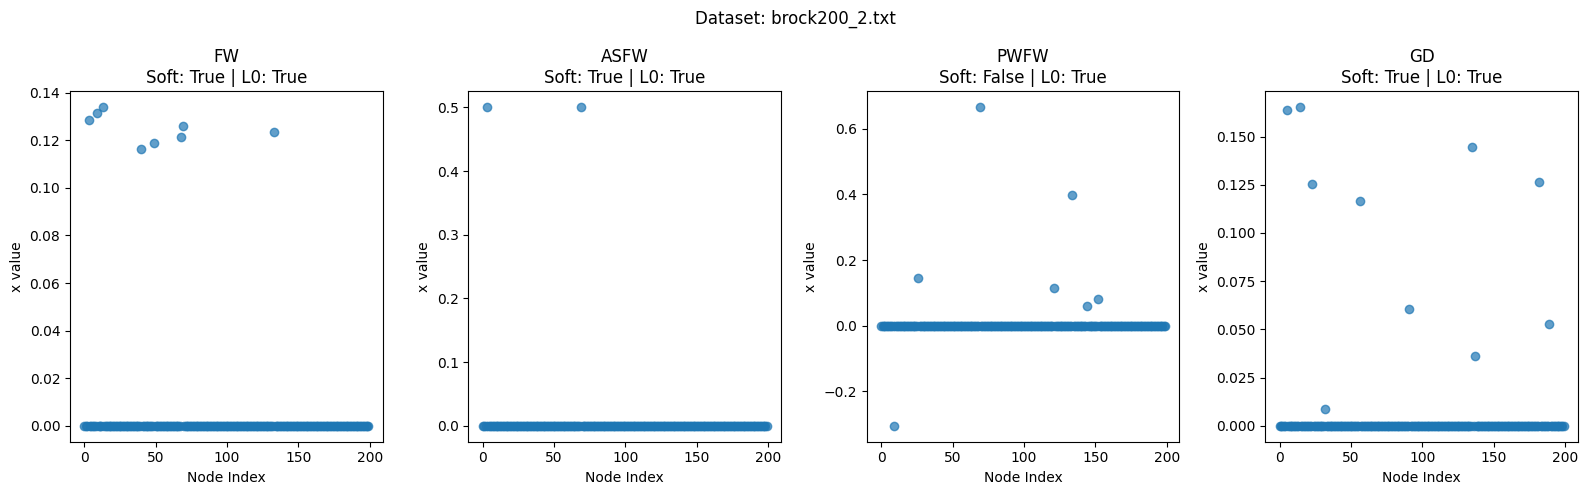

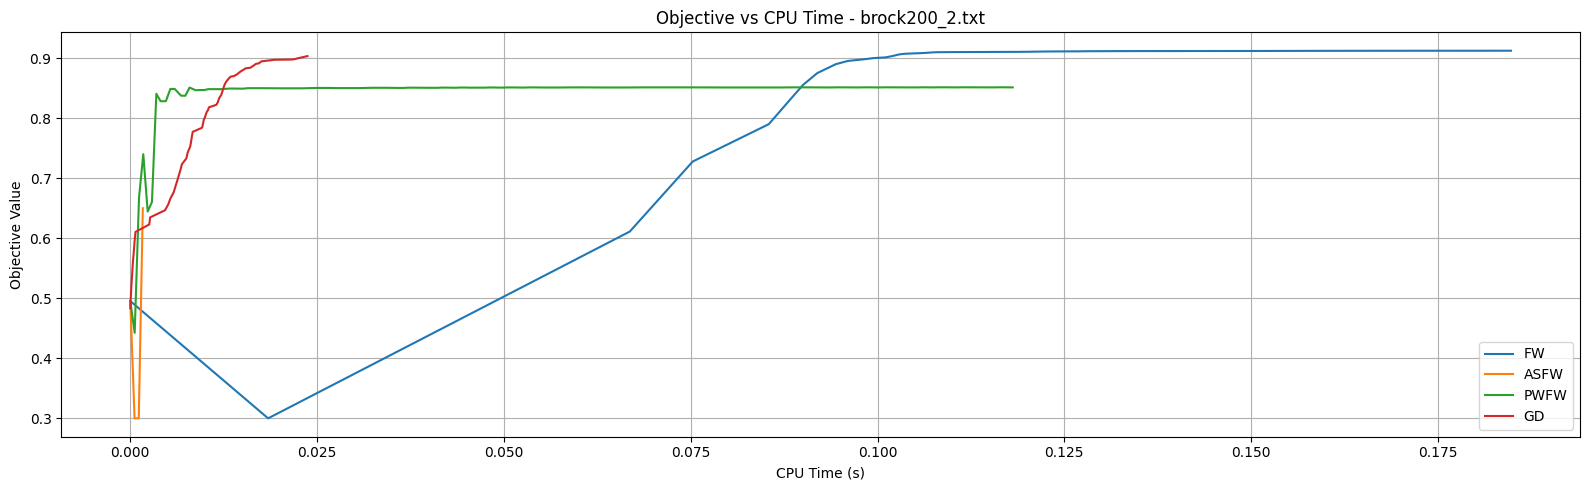

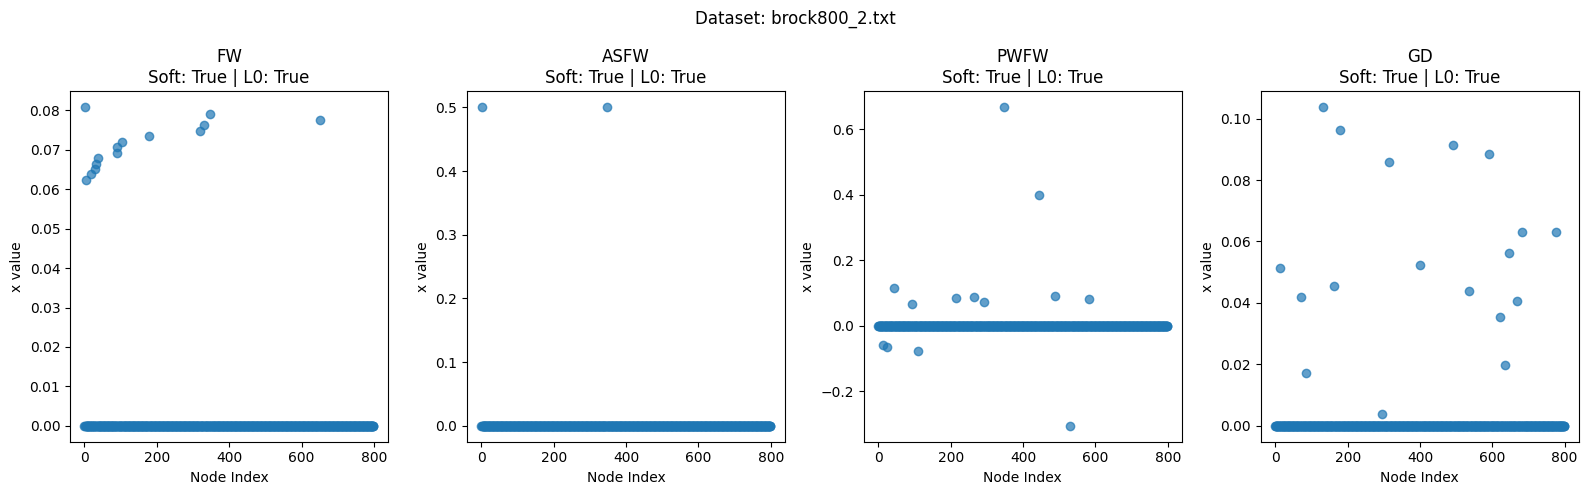

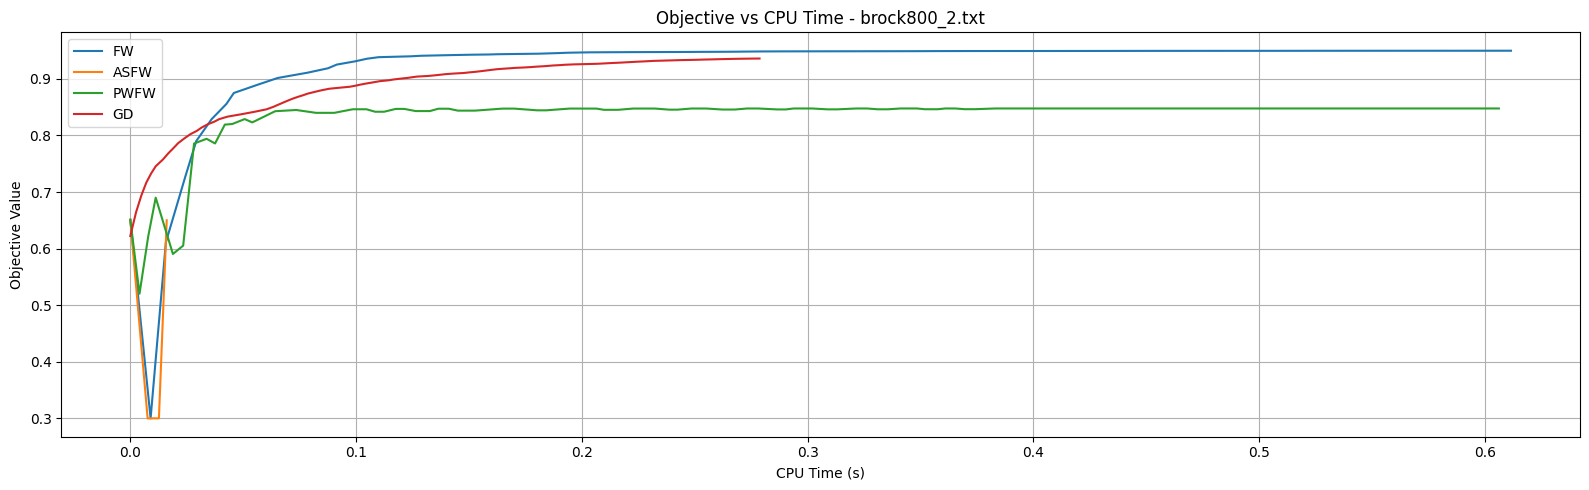

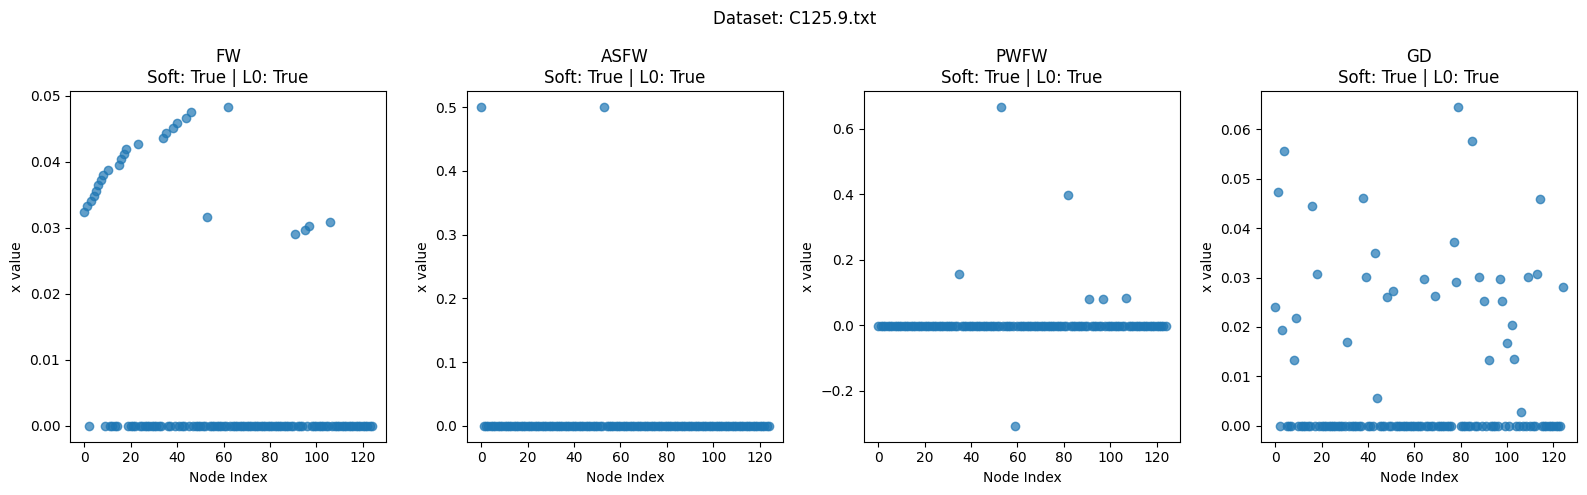

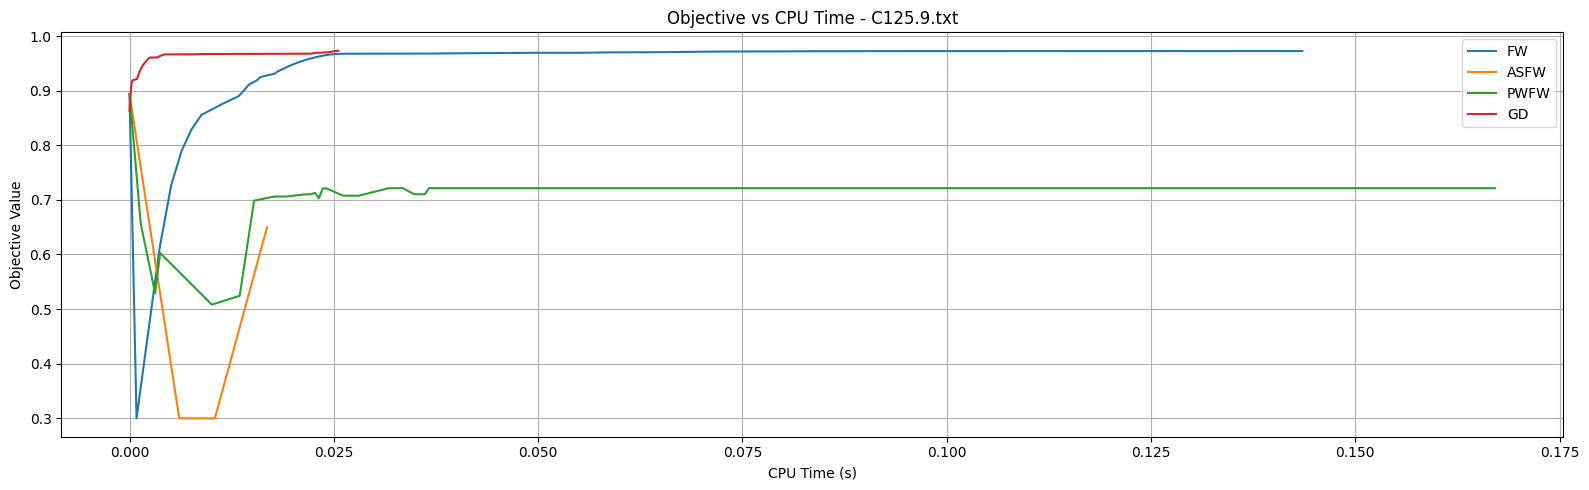

In [18]:
# Group all algorithms
algorithms = {
    "FW": frank_wolfe_clique,
    "ASFW": as_frank_wolfe_clique,
    "PWFW": pw_frank_wolfe_clique,
    "GD": p_grad_desc_clique
}

# Redefine core utilities
def run_all_fw_variants_on_datasets(datasets, algorithms):
    results = []
    for file_path in datasets:
        adj_matrix = text_to_adjacency_matrix(file_path)
        dataset_result = {
            "dataset": file_path.split("/")[-1],
            "shape": adj_matrix.shape,
            "algorithms": []
        }
        for name, algo_func in algorithms.items():
            x_opt, cput, obj = algo_func(adj_matrix)
            x_l0 = l0_postprocess(x_opt, threshold=0.2)
            is_soft_clique = is_clique(adj_matrix, np.where(x_opt > 5e-2)[0])
            is_hard_clique = is_clique(adj_matrix, np.where(x_l0 > 0)[0])
            dataset_result["algorithms"].append({
                "name": name,
                "x_opt": x_opt,
                "cpu_time": cput,
                "objective": obj,
                "is_soft_clique": is_soft_clique,
                "is_l0_clique": is_hard_clique
            })
        results.append(dataset_result)
    return results

def plot_combined_results(results):
    for data in results:
        dataset_name = data["dataset"]
        plt.figure(figsize=(16, 5))
        for i, algo in enumerate(data["algorithms"]):
            plt.subplot(1, len(data["algorithms"]), i+1)
            plt.scatter(np.arange(len(algo["x_opt"])), algo["x_opt"], alpha=0.7)
            plt.title(f"{algo['name']}\nSoft: {algo['is_soft_clique']} | L0: {algo['is_l0_clique']}")
            plt.xlabel("Node Index")
            plt.ylabel("x value")
        plt.suptitle(f"Dataset: {dataset_name}")
        plt.tight_layout()
        plt.show()

        # Plot objective vs CPU time
        plt.figure(figsize=(16, 5))
        for algo in data["algorithms"]:
            plt.plot(algo["cpu_time"], algo["objective"], label=algo["name"])
        plt.title(f"Objective vs CPU Time - {dataset_name}")
        plt.xlabel("CPU Time (s)")
        plt.ylabel("Objective Value")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run and plot results
fw_results = run_all_fw_variants_on_datasets(DATA_SETS, algorithms)
plot_combined_results(fw_results)